# Age Group Analysis: χ² Testing and Embedding-based Clustering

This notebook analyzes the BNC2014 corpus data to examine age-linked patterns in language use through:

1. **χ² Statistical Testing**: To identify statistically significant differences in word usage between age groups
2. **Embedding-based Clustering**: To explore semantic similarity and topic salience between speakers of different ages

We'll analyze two different age group classifications:
- **Binary Classification**: Young (0-29) vs. Old (30+)
- **Three-class Classification**: Young (0-29), Middle-aged (30-59), and Senior (60+)

In [17]:
# Import required libraries
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import lxml.etree as ET
from wordcloud import WordCloud

# Statistical analysis
from scipy.stats import chi2_contingency
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Dimensionality reduction and clustering
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
import umap

# Visualization
import plotly.express as px
import plotly.graph_objects as go

# NLP and embeddings
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import gensim.downloader as api

# Load pre-trained word embeddings
try:
    # Check if we can load from gensim
    word_vectors = api.load("glove-wiki-gigaword-100")
    print("Loaded GloVe word embeddings")
except Exception as e:
    print(f"Could not load pre-trained word embeddings: {e}")
    print("Will create embeddings from scratch if needed")

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

C:\Users\jubal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



Loaded GloVe word embeddings


In [18]:
# %pip install umap-learn

Loaded metadata for 671 speakers

Sample of speaker metadata:
      exactage  age1994 agerange gender      nat  \
S0001       32    25_34    30_39      F  British   
S0002      NaN  Unknown    19_29      F  British   
S0003      NaN  Unknown    19_29      F  British   
S0004      NaN  Unknown    30_39      M  British   
S0005      NaN   60plus    80_89      F  British   

                               birthplace birthcountry       l1 lingorig  \
S0001             Wordsley, West Midlands      England  English  England   
S0002                          Birmingham      England  English  England   
S0003  Royal Leamington Spa, Warwickshire      England  English  England   
S0004                                 NaN      Germany  English  England   
S0005                          Birmingham      England  English  England   

          dialect_rep  ...   dialect_l2   dialect_l3   dialect_l4  \
S0001  None indicated  ...  unspecified  unspecified  unspecified   
S0002        Midlands  ...    

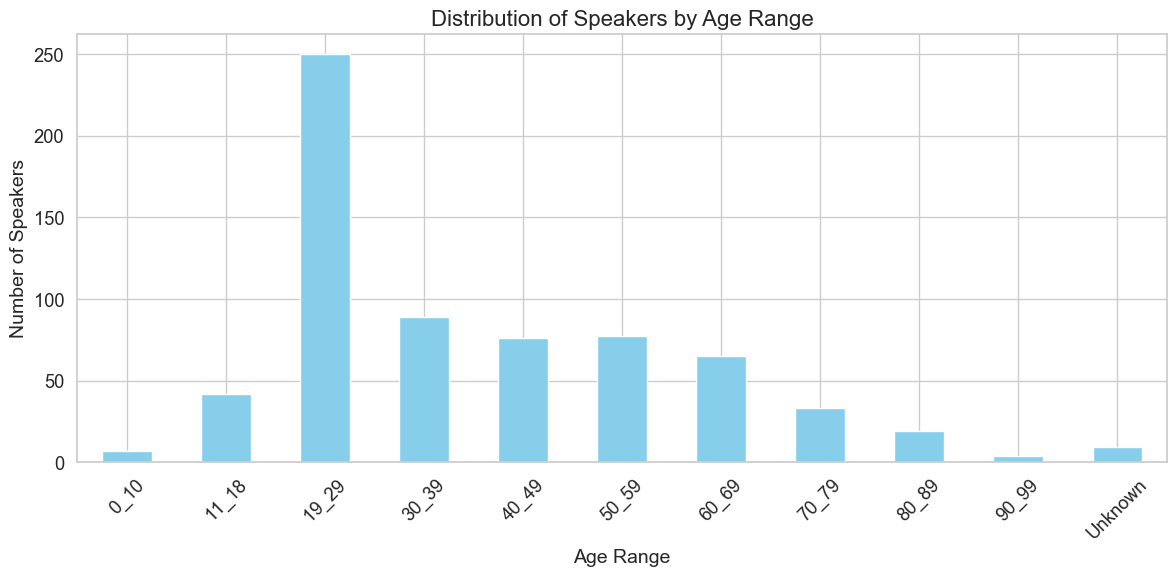

In [31]:
# Set the path to the dataset
path = 'Dataset'  
dir_corpus = os.path.join(path, 'spoken', 'tagged')
dir_meta = os.path.join(path, 'spoken', 'metadata')

# Load speaker metadata
fields_s = pd.read_csv(
    os.path.join(dir_meta, 'metadata-fields-speaker.txt'),
    sep='\t', skiprows=1, index_col=0
)

# Load the speaker metadata
df_speakers_meta = pd.read_csv(
    os.path.join(dir_meta, 'bnc2014spoken-speakerdata.tsv'),
    sep='\t', names=fields_s['XML tag'], index_col=0
)

print(f"Loaded metadata for {len(df_speakers_meta)} speakers")
print("\nSample of speaker metadata:")
print(df_speakers_meta.head())

# Check the distribution of age ranges in the metadata
print("\nAge range distribution:")
age_counts = df_speakers_meta['agerange'].value_counts().sort_index()
print(age_counts)

# Visualize age distribution
plt.figure(figsize=(12, 6))
age_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Speakers by Age Range', fontsize=16)
plt.xlabel('Age Range', fontsize=14)
plt.ylabel('Number of Speakers', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Create Binary and Three-class Age Groups

We'll create two different age group classifications:

1. **Binary Classification**:
   - **Young**: Speakers aged 0-29 years
   - **Old**: Speakers aged 30+ years

2. **Three-class Classification**:
   - **Young**: Speakers aged 0-29 years
   - **Middle-aged**: Speakers aged 30-59 years
   - **Senior**: Speakers aged 60+ years

Distribution of speakers by binary age classification:
binary_age
Old      363
Young    299
Name: count, dtype: int64
Percentage: Young 45.2%, Old 54.8%

Distribution of speakers by three-class age classification:
three_class_age
Young          299
Middle-aged    242
Senior         121
Name: count, dtype: int64
Percentage: Young 45.2%, Middle-aged 36.6%, Senior 18.3%


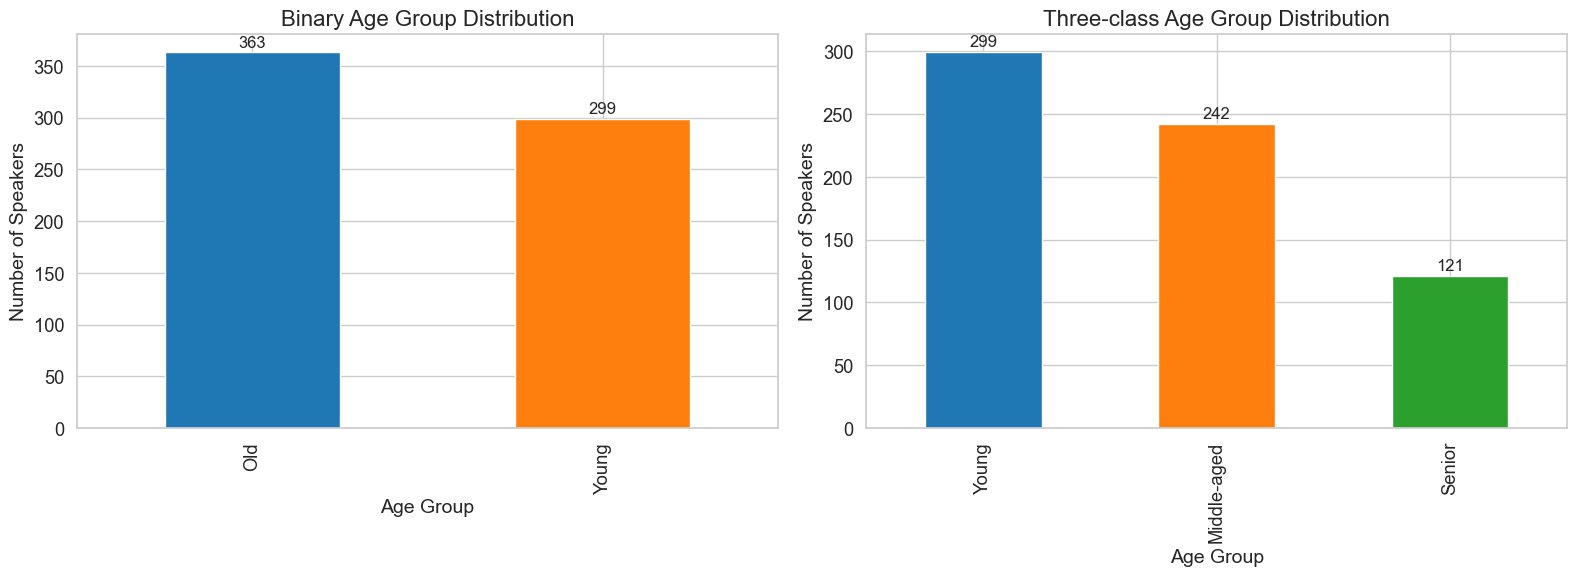

In [32]:
# Function to map BNC age ranges to binary categories
def map_to_binary_age(age_range):
    """
    Map BNC age ranges to binary categories:
    Young (0-29) vs Old (30+)
    
    Parameters:
    -----------
    age_range : str
        Age range from BNC metadata (e.g., '0_18', '19-29', '30_59', '60_plus')
        
    Returns:
    --------
    str
        'Young' or 'Old' classification
    """
    if pd.isna(age_range) or age_range == 'Unknown':
        return np.nan
    
    # Handle different formats in the age range field
    try:
        # Extract the upper bound of the age range
        if '_' in str(age_range):
            ages = str(age_range).split('_')
        elif '-' in str(age_range):
            ages = str(age_range).split('-')
        else:
            # Skip unknown formats
            return np.nan
        
        # Parse the upper bound
        if ages[1] == 'plus':
            upper = 100  # Arbitrarily high for '60_plus'
        else:
            upper = int(ages[1])
        
        # Classify as young or old
        if upper <= 29:
            return "Young"
        else:
            return "Old"
    except Exception as e:
        # Return np.nan for any errors
        return np.nan

# Function to map BNC age ranges to three classes
def map_to_three_class_age(age_range):
    """
    Map BNC age ranges to three categories:
    Young (0-29), Middle-aged (30-59), Senior (60+)
    
    Parameters:
    -----------
    age_range : str
        Age range from BNC metadata (e.g., '0_18', '19-29', '30_59', '60_plus')
        
    Returns:
    --------
    str
        'Young', 'Middle-aged', or 'Senior' classification
    """
    if pd.isna(age_range) or age_range == 'Unknown':
        return np.nan
    
    # Handle different formats in the age range field
    try:
        # Extract the upper bound of the age range
        if '_' in str(age_range):
            ages = str(age_range).split('_')
        elif '-' in str(age_range):
            ages = str(age_range).split('-')
        else:
            # Skip unknown formats
            return np.nan
        
        # Parse the upper bound
        if ages[1] == 'plus':
            upper = 100  # Arbitrarily high for '60_plus'
        else:
            upper = int(ages[1])
        
        # Classify into three age groups
        if upper <= 29:
            return "Young"
        elif upper <= 59:
            return "Middle-aged"
        else:
            return "Senior"
    except Exception as e:
        # Return np.nan for any errors
        return np.nan

# Apply both age classification schemes to speaker metadata
df_speakers_meta['binary_age'] = df_speakers_meta['agerange'].apply(map_to_binary_age)
df_speakers_meta['three_class_age'] = df_speakers_meta['agerange'].apply(map_to_three_class_age)

# Display counts for binary age groups
binary_age_counts = df_speakers_meta['binary_age'].value_counts()
print("Distribution of speakers by binary age classification:")
print(binary_age_counts)
print(f"Percentage: Young {100 * binary_age_counts['Young'] / binary_age_counts.sum():.1f}%, "
      f"Old {100 * binary_age_counts['Old'] / binary_age_counts.sum():.1f}%")

# Display counts for three-class age groups
three_class_age_counts = df_speakers_meta['three_class_age'].value_counts()
print("\nDistribution of speakers by three-class age classification:")
print(three_class_age_counts)
percentages = 100 * three_class_age_counts / three_class_age_counts.sum()
print(f"Percentage: Young {percentages['Young']:.1f}%, "
      f"Middle-aged {percentages['Middle-aged']:.1f}%, "
      f"Senior {percentages['Senior']:.1f}%")

# Visualize both age group distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Binary age distribution
binary_age_counts.plot(kind='bar', ax=ax1, color=['#1f77b4', '#ff7f0e'])
ax1.set_title('Binary Age Group Distribution', fontsize=16)
ax1.set_xlabel('Age Group', fontsize=14)
ax1.set_ylabel('Number of Speakers', fontsize=14)

# Add count labels on top of bars
for i, count in enumerate(binary_age_counts):
    ax1.text(i, count + 5, str(count), ha='center', fontsize=12)

# Three-class age distribution
three_class_age_counts.plot(kind='bar', ax=ax2, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax2.set_title('Three-class Age Group Distribution', fontsize=16)
ax2.set_xlabel('Age Group', fontsize=14)
ax2.set_ylabel('Number of Speakers', fontsize=14)

# Add count labels on top of bars
for i, count in enumerate(three_class_age_counts):
    ax2.text(i, count + 5, str(count), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

In [33]:
# Process tagged corpus files to extract word data
# Limit to a number of files to keep processing time reasonable
file_limit = 1251  # Adjust based on your computational resources

tagged_rows = []
try:
    # Load corpus files
    for file_count, fname in enumerate(sorted(os.listdir(dir_corpus))[:file_limit]):
        # Print progress every 5 files
        if file_count % 5 == 0:
            print(f"Processing file {file_count+1}/{file_limit}: {fname}")
            
        fpath = os.path.join(dir_corpus, fname)
        xml = ET.parse(fpath)
        root = xml.getroot()
        text_id = root.get('id')
        
        for u in root.findall('.//u'):
            utt_id = u.get('n')
            spk = u.get('who')
            for w in u.findall('w'):
                tagged_rows.append({
                    'text_id': text_id,
                    'utterance_id': utt_id,
                    'speaker_id': spk,
                    'word': w.text,
                    'lemma': w.get('lemma'),
                    'pos': w.get('pos'),
                    'class': w.get('class'),
                    'usas': w.get('usas'),
                })
    
    # Create a DataFrame from the extracted data
    df_tagged = pd.DataFrame(tagged_rows)
    
    print(f"\nLoaded {len(df_tagged)} word tokens from {file_limit} files")
    print(f"Found {df_tagged['speaker_id'].nunique()} unique speakers in the processed data")
    
except Exception as e:
    print(f"Error loading corpus data: {e}")

# Count of speakers with valid age data
valid_binary_age_speakers = set(df_speakers_meta[~df_speakers_meta['binary_age'].isna()].index)
valid_three_class_speakers = set(df_speakers_meta[~df_speakers_meta['three_class_age'].isna()].index)
tagged_speakers = set(df_tagged['speaker_id'].unique())

valid_binary_speakers = valid_binary_age_speakers.intersection(tagged_speakers)
valid_three_class_speakers = valid_three_class_speakers.intersection(tagged_speakers)

print(f"\nOf {len(tagged_speakers)} speakers in the corpus data:")
print(f"- {len(valid_binary_speakers)} have valid binary age data")
print(f"- {len(valid_three_class_speakers)} have valid three-class age data")

# Filter to only include speakers with valid age data
df_tagged_valid = df_tagged[df_tagged['speaker_id'].isin(valid_binary_speakers)]
print(f"Filtered corpus data contains {len(df_tagged_valid)} word tokens from {len(valid_binary_speakers)} speakers")

Processing file 1/1251: S23A-tgd.xml
Processing file 6/1251: S26N-tgd.xml
Processing file 6/1251: S26N-tgd.xml
Processing file 11/1251: S2A5-tgd.xml
Processing file 11/1251: S2A5-tgd.xml
Processing file 16/1251: S2CY-tgd.xml
Processing file 16/1251: S2CY-tgd.xml
Processing file 21/1251: S2FT-tgd.xml
Processing file 26/1251: S2K6-tgd.xml
Processing file 21/1251: S2FT-tgd.xml
Processing file 26/1251: S2K6-tgd.xml
Processing file 31/1251: S2NQ-tgd.xml
Processing file 31/1251: S2NQ-tgd.xml
Processing file 36/1251: S2T6-tgd.xml
Processing file 36/1251: S2T6-tgd.xml
Processing file 41/1251: S2UT-tgd.xml
Processing file 41/1251: S2UT-tgd.xml
Processing file 46/1251: S2YK-tgd.xml
Processing file 46/1251: S2YK-tgd.xml
Processing file 51/1251: S33B-tgd.xml
Processing file 51/1251: S33B-tgd.xml
Processing file 56/1251: S35U-tgd.xml
Processing file 56/1251: S35U-tgd.xml
Processing file 61/1251: S37K-tgd.xml
Processing file 61/1251: S37K-tgd.xml
Processing file 66/1251: S38V-tgd.xml
Processing file

In [34]:
# Create a speaker-based DataFrame
# This will be used for both binary and three-class analyses

# Initialize empty DataFrame to store speaker data
speaker_df = pd.DataFrame()

# Dictionary to store speaker texts and features
speaker_data = {}

# Group by speaker_id to aggregate texts and calculate features
for speaker_id, group in df_tagged_valid.groupby('speaker_id'):
    if speaker_id in df_speakers_meta.index:
        # Extract words and utterances for this speaker
        words = group['word'].fillna('').tolist()
        lemmas = group['lemma'].fillna('').tolist()
        
        # Create a text document of all the speaker's words
        text = ' '.join([w.lower() for w in words if w])
        
        # Calculate features
        total_words = len([w for w in words if w])
        unique_words = len(set([w.lower() for w in words if w]))
        
        # Group by utterance and calculate utterance-level features
        utterances = []
        utt_lengths = []
        
        for utt_id, utt_group in group.groupby('utterance_id'):
            utt_words = utt_group['word'].fillna('').tolist()
            if utt_words:
                utt_text = ' '.join([w for w in utt_words if w])
                utterances.append(utt_text)
                utt_lengths.append(len(utt_words))
        
        # Store data for this speaker
        speaker_data[speaker_id] = {
            'text': text,
            'binary_age': df_speakers_meta.loc[speaker_id, 'binary_age'],
            'three_class_age': df_speakers_meta.loc[speaker_id, 'three_class_age'],
            'gender': df_speakers_meta.loc[speaker_id, 'gender'],
            'total_words': total_words,
            'unique_words': unique_words,
            'vocab_size': unique_words,
            'lexical_diversity': unique_words / total_words if total_words > 0 else 0,
            'utterances': utterances,
            'num_utterances': len(utterances),
            'avg_utterance_length': np.mean(utt_lengths) if utt_lengths else 0,
            'all_utterances': ' '.join(utterances)
        }

# Convert to DataFrame
speaker_df = pd.DataFrame.from_dict(speaker_data, orient='index')

# Display speaker DataFrame info
print(f"Created speaker-based DataFrame with {len(speaker_df)} speakers")
print(f"Number of speakers by binary age group:")
print(speaker_df['binary_age'].value_counts())
print(f"\nNumber of speakers by three-class age group:")
print(speaker_df['three_class_age'].value_counts())

# Show sample of the speaker DataFrame
print("\nSample of speaker DataFrame:")
print(speaker_df[['binary_age', 'three_class_age', 'gender', 'total_words', 'vocab_size', 'lexical_diversity', 'avg_utterance_length']].head())

Created speaker-based DataFrame with 662 speakers
Number of speakers by binary age group:
binary_age
Old      363
Young    299
Name: count, dtype: int64

Number of speakers by three-class age group:
three_class_age
Young          299
Middle-aged    242
Senior         121
Name: count, dtype: int64

Sample of speaker DataFrame:
      binary_age three_class_age gender  total_words  vocab_size  \
S0001        Old     Middle-aged      F         2890         673   
S0002      Young           Young      F         8481        1161   
S0003      Young           Young      F         1876         406   
S0004        Old     Middle-aged      M         3626         888   
S0005        Old          Senior      F         1438         346   

       lexical_diversity  avg_utterance_length  
S0001           0.232872              7.565445  
S0002           0.136894             15.793296  
S0003           0.216418             11.233533  
S0004           0.244898             10.856287  
S0005           0.

## Chi-Square (χ²) Testing for Word Association with Age Groups

We'll perform Chi-Square tests to identify words that are significantly associated with specific age groups. This will help us understand which words are characteristic of different age groups.

We'll analyze:
1. Binary age groups (Young vs. Old)
2. Three-class age groups (Young, Middle-aged, Senior)

In [35]:
def perform_chi_square_analysis(df_tagged, speaker_ids_by_group, min_count=5, max_words=100):
    """
    Perform Chi-Square test to identify words significantly associated with age groups
    
    Parameters:
    -----------
    df_tagged : pandas.DataFrame
        DataFrame with the tagged words
    speaker_ids_by_group : dict
        Dictionary mapping group names to lists of speaker IDs
    min_count : int
        Minimum count for a word to be considered in analysis
    max_words : int
        Maximum number of top words to return by significance
        
    Returns:
    --------
    tuple
        (significant_words_df, contingency_tables_dict)
    """
    # Define basic stopwords to exclude function words
    stopwords_list = [
        'the', 'and', 'to', 'a', 'of', 'in', 'i', 'it', 'that', 'you', 'is', 'for', 'on', 
        'have', 'with', 'be', 'this', 'are', 'was', 'but', 'not', 'they', 'so', 'we', 'what'
    ]
    
    # Collect all words from each group
    group_words = {}
    group_word_counts = {}
    total_words_by_group = {}
    
    # First pass - collect words and counts by group
    for group, speaker_ids in speaker_ids_by_group.items():
        # Get all words from speakers in this group
        words = df_tagged[df_tagged['speaker_id'].isin(speaker_ids)]['word'].dropna()
        
        # Clean and normalize words
        clean_words = []
        for word in words:
            word = str(word).lower()
            # Keep only alphabetic words, remove punctuation and numbers
            if word.isalpha() and len(word) > 1 and word not in stopwords_list:
                clean_words.append(word)
        
        # Store words for this group
        group_words[group] = clean_words
        group_word_counts[group] = Counter(clean_words)
        total_words_by_group[group] = len(clean_words)
    
    # Find all unique words across all groups that meet minimum count
    all_words = set()
    for group, word_counter in group_word_counts.items():
        for word, count in word_counter.items():
            if count >= min_count:
                all_words.add(word)
    
    print(f"Found {len(all_words)} unique words with minimum count of {min_count}")
    
    # Create contingency tables for each word
    word_tables = {}
    word_chi2 = {}
    word_pvalues = {}
    
    for word in all_words:
        # Create a 2xN contingency table for this word
        # Rows: [word_count, other_words_count]
        # Columns: Group1, Group2, Group3, ...
        contingency_table = []
        
        # Row 1: Count of this word in each group
        word_row = [group_word_counts[group].get(word, 0) for group in speaker_ids_by_group.keys()]
        
        # Row 2: Count of other words in each group
        other_row = [total_words_by_group[group] - group_word_counts[group].get(word, 0) 
                     for group in speaker_ids_by_group.keys()]
        
        contingency_table = [word_row, other_row]
        
        # Calculate chi-square statistic
        try:
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            word_tables[word] = contingency_table
            word_chi2[word] = chi2
            word_pvalues[word] = p
        except Exception as e:
            print(f"Error calculating chi-square for word '{word}': {e}")
    
    # Create DataFrame with results
    results = []
    for word, chi2 in sorted(word_chi2.items(), key=lambda x: x[1], reverse=True):
        # Calculate frequencies per 1000 words for each group
        freqs = {}
        for i, group in enumerate(speaker_ids_by_group.keys()):
            count = word_tables[word][0][i]
            total = total_words_by_group[group]
            freq_per_1000 = (count / total) * 1000
            freqs[f"{group}_freq"] = freq_per_1000
        
        # Find the group with the highest frequency
        highest_group = max(freqs.items(), key=lambda x: x[1])[0].replace('_freq', '')
        
        results.append({
            'word': word,
            'chi2': chi2,
            'p_value': word_pvalues[word],
            'highest_group': highest_group,
            **freqs
        })
    
    # Convert to DataFrame and sort by chi-square value
    results_df = pd.DataFrame(results)
    significant_df = results_df[results_df['p_value'] < 0.05].sort_values('chi2', ascending=False).reset_index(drop=True)
    
    # Limit to max_words if specified
    if max_words and len(significant_df) > max_words:
        significant_df = significant_df.head(max_words)
    
    return significant_df, word_tables

Performing Chi-Square analysis for binary age groups...
Found 12127 unique words with minimum count of 10
Found 12127 unique words with minimum count of 10
Found 50 words significantly associated with binary age groups (p < 0.05)

Top 20 words by chi-square value:
       word          chi2        p_value highest_group  Young_freq   Old_freq
0      like  42437.596006   0.000000e+00         Young   38.195500  12.973212
1       yes   5643.616188   0.000000e+00           Old    2.227125   6.193396
2        mm   5611.852940   0.000000e+00           Old    8.976776  15.643268
3      well   3137.181655   0.000000e+00           Old    8.447742  13.101828
4     right   2829.857394   0.000000e+00           Old    3.318806   6.294532
5      just   2551.126319   0.000000e+00         Young   15.709270  11.125279
6        my   2360.074649   0.000000e+00         Young    8.087466   5.007523
7    really   2192.090649   0.000000e+00         Young    9.263175   6.050615
8      said   1954.964812   0.000

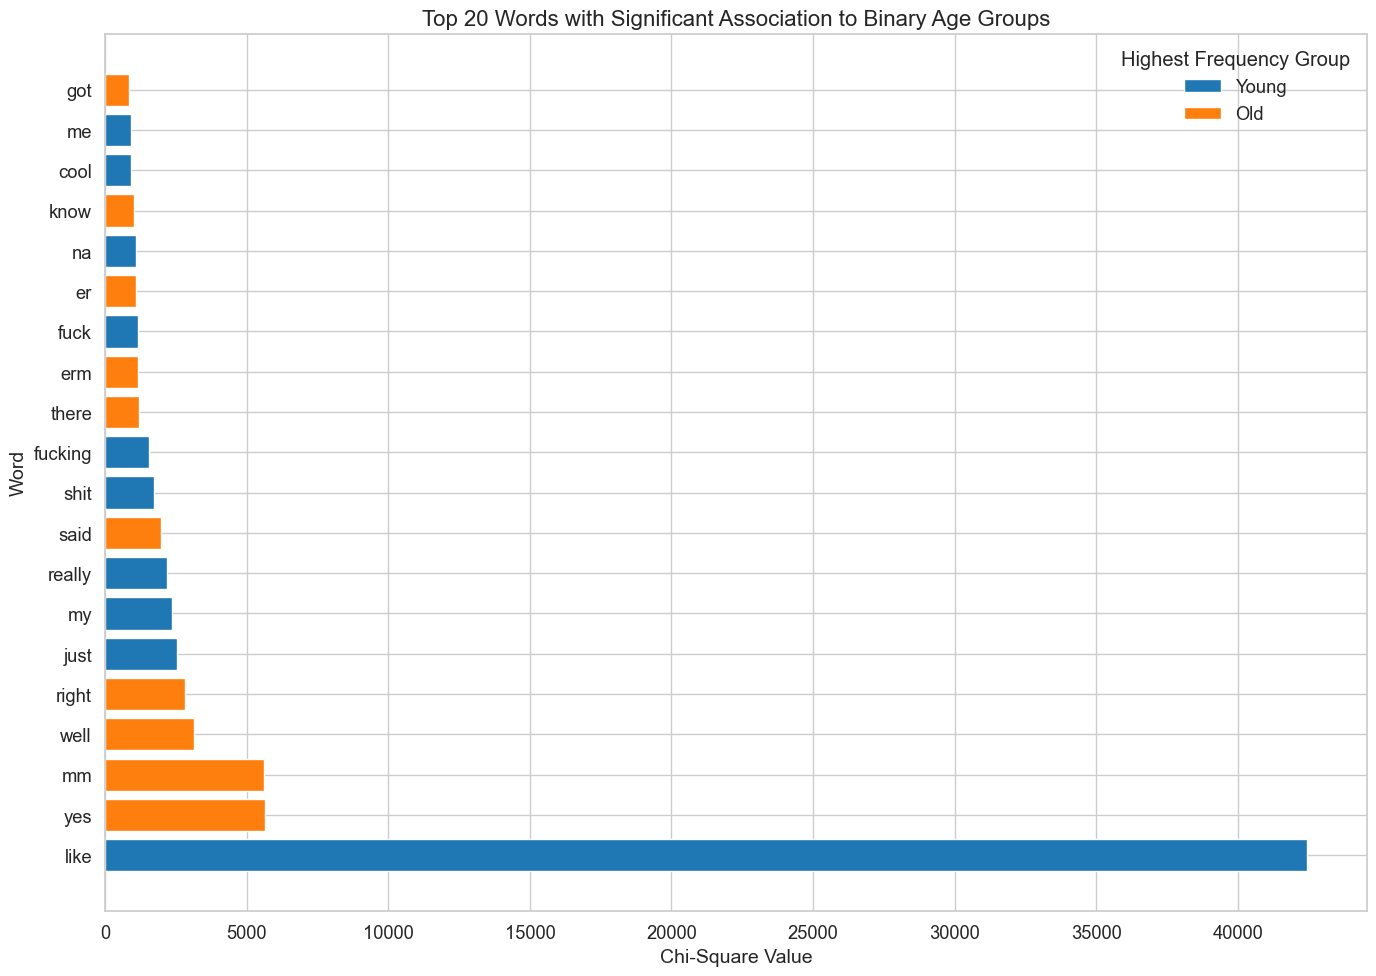

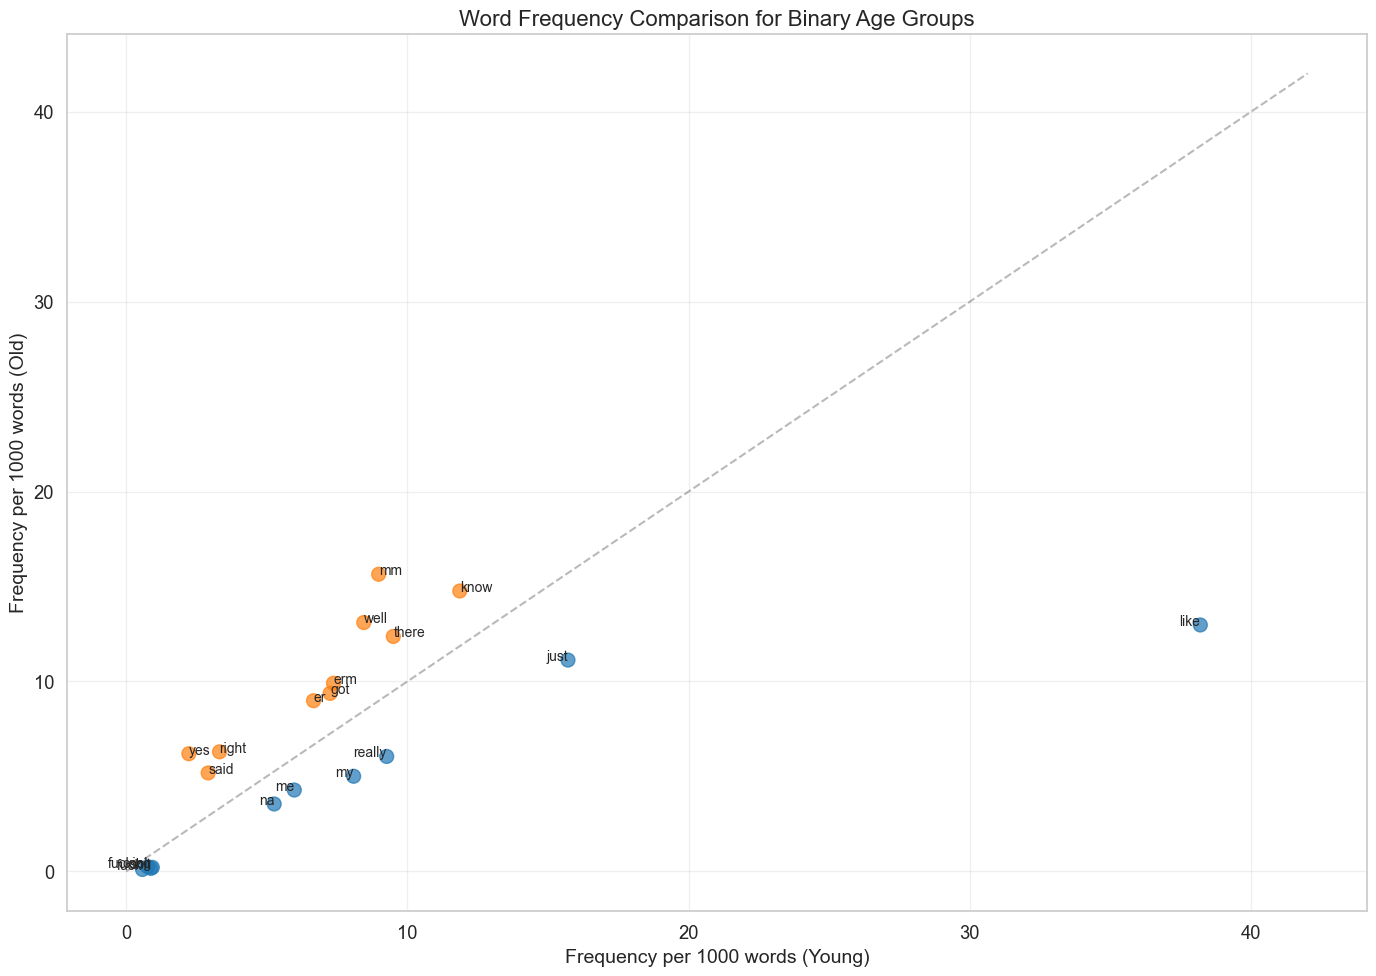

In [36]:
# Perform Chi-Square analysis for binary age groups

# Get speaker IDs for each binary age group
binary_speaker_ids = {
    'Young': speaker_df[speaker_df['binary_age'] == 'Young'].index.tolist(),
    'Old': speaker_df[speaker_df['binary_age'] == 'Old'].index.tolist()
}

print("Performing Chi-Square analysis for binary age groups...")
binary_chi2_results, binary_tables = perform_chi_square_analysis(
    df_tagged_valid, 
    binary_speaker_ids,
    min_count=10,
    max_words=50
)

print(f"Found {len(binary_chi2_results)} words significantly associated with binary age groups (p < 0.05)")
print("\nTop 20 words by chi-square value:")
print(binary_chi2_results[['word', 'chi2', 'p_value', 'highest_group', 'Young_freq', 'Old_freq']].head(20))

# Visualize the top words
plt.figure(figsize=(14, 10))
top_words = binary_chi2_results.head(20)

# Create a colormap based on the highest frequency group
colors = ['#1f77b4' if group == 'Young' else '#ff7f0e' for group in top_words['highest_group']]

# Plot chi-square values
plt.barh(top_words['word'], top_words['chi2'], color=colors)
plt.xlabel('Chi-Square Value', fontsize=14)
plt.ylabel('Word', fontsize=14)
plt.title('Top 20 Words with Significant Association to Binary Age Groups', fontsize=16)

# Add a legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#1f77b4', label='Young'),
    Patch(facecolor='#ff7f0e', label='Old')
]
plt.legend(handles=legend_elements, title='Highest Frequency Group')

plt.tight_layout()
plt.show()

# Visualize the frequency comparison
plt.figure(figsize=(14, 10))

# Create a scatterplot of word frequencies
plt.scatter(
    top_words['Young_freq'], 
    top_words['Old_freq'],
    c=colors,
    s=100,
    alpha=0.7
)

# Add word labels
for i, row in top_words.iterrows():
    plt.annotate(
        row['word'],
        (row['Young_freq'], row['Old_freq']),
        fontsize=10,
        ha='right' if row['Young_freq'] > row['Old_freq'] else 'left'
    )

# Add a diagonal line
max_freq = max(top_words['Young_freq'].max(), top_words['Old_freq'].max()) * 1.1
plt.plot([0, max_freq], [0, max_freq], 'k--', alpha=0.3)

plt.xlabel('Frequency per 1000 words (Young)', fontsize=14)
plt.ylabel('Frequency per 1000 words (Old)', fontsize=14)
plt.title('Word Frequency Comparison for Binary Age Groups', fontsize=16)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Performing Chi-Square analysis for three-class age groups...
Found 12889 unique words with minimum count of 8
Found 12889 unique words with minimum count of 8
Found 50 words significantly associated with three-class age groups (p < 0.05)

Top 20 words by chi-square value:
       word          chi2        p_value highest_group  Young_freq  \
0      like  43773.132393   0.000000e+00         Young   38.195500   
1       yes   7460.057299   0.000000e+00        Senior    2.227125   
2        mm   7356.624678   0.000000e+00        Senior    8.976776   
3        er   5072.097682   0.000000e+00        Senior    6.661770   
4     right   4518.866314   0.000000e+00        Senior    3.318806   
5      well   3735.662356   0.000000e+00        Senior    8.447742   
6      just   3421.048350   0.000000e+00         Young   15.709270   
7        my   2464.165338   0.000000e+00         Young    8.087466   
8    really   2439.886879   0.000000e+00         Young    9.263175   
9        ai   2272.379084  

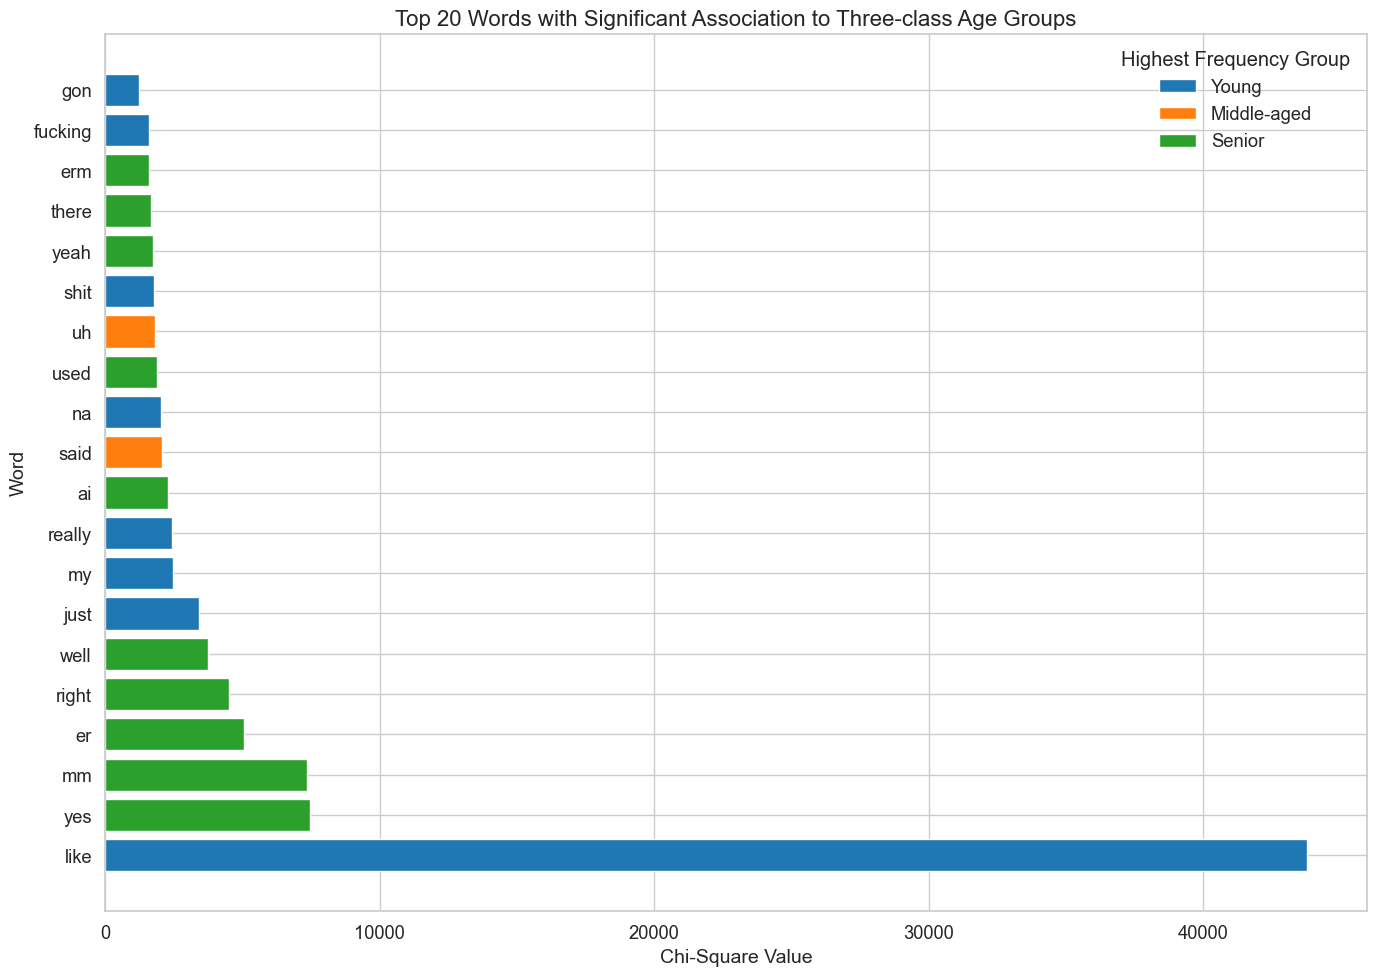

In [37]:
# Perform Chi-Square analysis for three-class age groups

# Get speaker IDs for each three-class age group
three_class_speaker_ids = {
    'Young': speaker_df[speaker_df['three_class_age'] == 'Young'].index.tolist(),
    'Middle-aged': speaker_df[speaker_df['three_class_age'] == 'Middle-aged'].index.tolist(),
    'Senior': speaker_df[speaker_df['three_class_age'] == 'Senior'].index.tolist()
}

print("Performing Chi-Square analysis for three-class age groups...")
three_class_chi2_results, three_class_tables = perform_chi_square_analysis(
    df_tagged_valid, 
    three_class_speaker_ids,
    min_count=8,
    max_words=50
)

print(f"Found {len(three_class_chi2_results)} words significantly associated with three-class age groups (p < 0.05)")
print("\nTop 20 words by chi-square value:")
print(three_class_chi2_results[['word', 'chi2', 'p_value', 'highest_group', 'Young_freq', 'Middle-aged_freq', 'Senior_freq']].head(20))

# Visualize the top words
plt.figure(figsize=(14, 10))
top_words = three_class_chi2_results.head(20)

# Create a colormap based on the highest frequency group
color_map = {
    'Young': '#1f77b4',
    'Middle-aged': '#ff7f0e',
    'Senior': '#2ca02c'
}
colors = [color_map[group] for group in top_words['highest_group']]

# Plot chi-square values
plt.barh(top_words['word'], top_words['chi2'], color=colors)
plt.xlabel('Chi-Square Value', fontsize=14)
plt.ylabel('Word', fontsize=14)
plt.title('Top 20 Words with Significant Association to Three-class Age Groups', fontsize=16)

# Add a legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=color_map['Young'], label='Young'),
    Patch(facecolor=color_map['Middle-aged'], label='Middle-aged'),
    Patch(facecolor=color_map['Senior'], label='Senior')
]
plt.legend(handles=legend_elements, title='Highest Frequency Group')

plt.tight_layout()
plt.show()

# Create a 3D scatter plot to visualize the three-way comparison
import plotly.express as px

# Prepare data for 3D plotting
plot_data = top_words[['word', 'Young_freq', 'Middle-aged_freq', 'Senior_freq', 'highest_group']].copy()

# Create 3D scatter plot with plotly
fig = px.scatter_3d(
    plot_data, 
    x='Young_freq', 
    y='Middle-aged_freq', 
    z='Senior_freq',
    color='highest_group',
    color_discrete_map=color_map,
    text='word',
    size=[10] * len(plot_data),  # Fixed size for all points
    opacity=0.8,
    title='Word Frequency Comparison for Three-class Age Groups',
    labels={
        'Young_freq': 'Frequency in Young (per 1000)',
        'Middle-aged_freq': 'Frequency in Middle-aged (per 1000)',
        'Senior_freq': 'Frequency in Senior (per 1000)'
    }
)

# Update marker settings to show text
fig.update_traces(
    marker=dict(size=5),
    hovertemplate="<b>%{text}</b><br>" +
                  "Young: %{x:.2f}<br>" +
                  "Middle-aged: %{y:.2f}<br>" +
                  "Senior: %{z:.2f}"
)

# Adjust layout
fig.update_layout(
    scene=dict(
        xaxis_title='Young Frequency',
        yaxis_title='Middle-aged Frequency',
        zaxis_title='Senior Frequency'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

## Word Embedding-based Clustering Analysis

Now we'll use word embeddings to analyze semantic similarity between speakers of different age groups. This will help us understand how age affects not just word choice but also semantic content and topic salience.

We'll create speaker embeddings by averaging the word embeddings for each speaker's text and then apply clustering algorithms to visualize age-based patterns.

In [38]:
# First, create document-term matrices for each age group classification

# Define a more comprehensive stopwords list
extended_stopwords = [
    # Common English stopwords
    'the', 'and', 'to', 'a', 'of', 'in', 'i', 'it', 'that', 'you', 'is', 
    'for', 'on', 'have', 'with', 'be', 'this', 'are', 'was', 'but', 'not', 
    'they', 'so', 'we', 'what', 
    
    # Fillers and hesitation markers
    'um', 'uh', 'er', 'erm', 'eh', 'mm', 'uhuh', 'oh', 'yeah', 'no', 'yes', 
    'well', 'just', 'like','hm',
    
    # More common words
    'there', 'then', 'do', 'can', 'would', 'will', 'if', 'or', 'from', 'an', 'at', 
    'by', 'your', 'my', 'their', 'his', 'her', 'our', 'as', 'all', 'about', 'because', 
    'been', 'has', 'had', 'get', 'got', 'very', 'really', 'some', 'which', 'when', 'where', 
    'how', 'why', 'who', 'them', 'these', 'those', 'did', 'does', 'doing', 'done'
]

# 1. Create TF-IDF matrices for binary age groups
print("Creating TF-IDF matrices for binary age groups...")
binary_tfidf = TfidfVectorizer(
    max_features=300,
    min_df=3,
    max_df=0.7,
    stop_words=extended_stopwords
)

binary_tfidf_matrix = binary_tfidf.fit_transform(speaker_df['text'])
binary_features = binary_tfidf.get_feature_names_out()

print(f"Created TF-IDF matrix with shape: {binary_tfidf_matrix.shape}")
print(f"Number of features: {len(binary_features)}")

# 2. Create TF-IDF matrices for three-class age groups
print("\nCreating TF-IDF matrices for three-class age groups...")
three_class_tfidf = TfidfVectorizer(
    max_features=300,
    min_df=3,
    max_df=0.7,
    stop_words=extended_stopwords
)

three_class_tfidf_matrix = three_class_tfidf.fit_transform(speaker_df['text'])
three_class_features = three_class_tfidf.get_feature_names_out()

print(f"Created TF-IDF matrix with shape: {three_class_tfidf_matrix.shape}")
print(f"Number of features: {len(three_class_features)}")

Creating TF-IDF matrices for binary age groups...
Created TF-IDF matrix with shape: (662, 300)
Number of features: 300

Creating TF-IDF matrices for three-class age groups...
Created TF-IDF matrix with shape: (662, 300)
Number of features: 300

Creating TF-IDF matrices for three-class age groups...
Created TF-IDF matrix with shape: (662, 300)
Number of features: 300
Created TF-IDF matrix with shape: (662, 300)
Number of features: 300


In [39]:
# Function to create speaker embeddings using pre-trained word vectors
def create_speaker_embeddings(texts, embedding_size=100):
    """
    Create speaker embeddings by averaging word embeddings for each speaker's text
    
    Parameters:
    -----------
    texts : list
        List of speaker texts
    embedding_size : int
        Size of the word embeddings
        
    Returns:
    --------
    numpy.ndarray
        Speaker embeddings matrix
    """
    speaker_embeddings = []
    
    for text in texts:
        # Tokenize the text
        tokens = text.lower().split()
        
        # Get word embeddings for each token
        token_embeddings = []
        for token in tokens:
            try:
                if token in word_vectors:
                    token_embeddings.append(word_vectors[token])
            except:
                # Skip tokens not in vocabulary
                continue
        
        # If no embeddings found, use a zero vector
        if not token_embeddings:
            speaker_embeddings.append(np.zeros(embedding_size))
        else:
            # Average the token embeddings
            speaker_embeddings.append(np.mean(token_embeddings, axis=0))
    
    return np.array(speaker_embeddings)

# Apply dimensionality reduction for visualization

def reduce_dimensions(embeddings, method='tsne', n_components=2):
    """
    Reduce dimensionality of embeddings for visualization
    
    Parameters:
    -----------
    embeddings : numpy.ndarray
        Speaker embeddings matrix
    method : str
        Dimensionality reduction method ('tsne', 'pca', or 'umap')
    n_components : int
        Number of dimensions to reduce to
        
    Returns:
    --------
    numpy.ndarray
        Reduced embeddings
    """
    if method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=RANDOM_SEED)
    elif method == 'pca':
        reducer = PCA(n_components=n_components, random_state=RANDOM_SEED)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=n_components, random_state=RANDOM_SEED)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    return reducer.fit_transform(embeddings)

# Create speaker embeddings from text
try:
    print("Creating speaker embeddings using pre-trained word vectors...")
    speaker_embeddings = create_speaker_embeddings(speaker_df['text'].tolist())
    print(f"Created speaker embeddings with shape: {speaker_embeddings.shape}")
    
    # Reduce dimensions for visualization
    print("\nReducing dimensions for visualization...")
    tsne_embeddings = reduce_dimensions(speaker_embeddings, method='tsne')
    pca_embeddings = reduce_dimensions(speaker_embeddings, method='pca')
    
    print(f"Created t-SNE embeddings with shape: {tsne_embeddings.shape}")
    print(f"Created PCA embeddings with shape: {pca_embeddings.shape}")
    
except Exception as e:
    print(f"Error creating speaker embeddings: {e}")
    print("Using TF-IDF matrix for dimensionality reduction instead...")
    
    # Use TF-IDF matrix instead
    print("\nReducing dimensions of TF-IDF matrix for visualization...")
    tsne_embeddings = reduce_dimensions(binary_tfidf_matrix.toarray(), method='tsne')
    pca_embeddings = reduce_dimensions(binary_tfidf_matrix.toarray(), method='pca')
    
    print(f"Created t-SNE embeddings with shape: {tsne_embeddings.shape}")
    print(f"Created PCA embeddings with shape: {pca_embeddings.shape}")

Creating speaker embeddings using pre-trained word vectors...
Created speaker embeddings with shape: (662, 100)

Reducing dimensions for visualization...
Created speaker embeddings with shape: (662, 100)

Reducing dimensions for visualization...
Created t-SNE embeddings with shape: (662, 2)
Created PCA embeddings with shape: (662, 2)
Created t-SNE embeddings with shape: (662, 2)
Created PCA embeddings with shape: (662, 2)


Visualizing embeddings by binary age group...


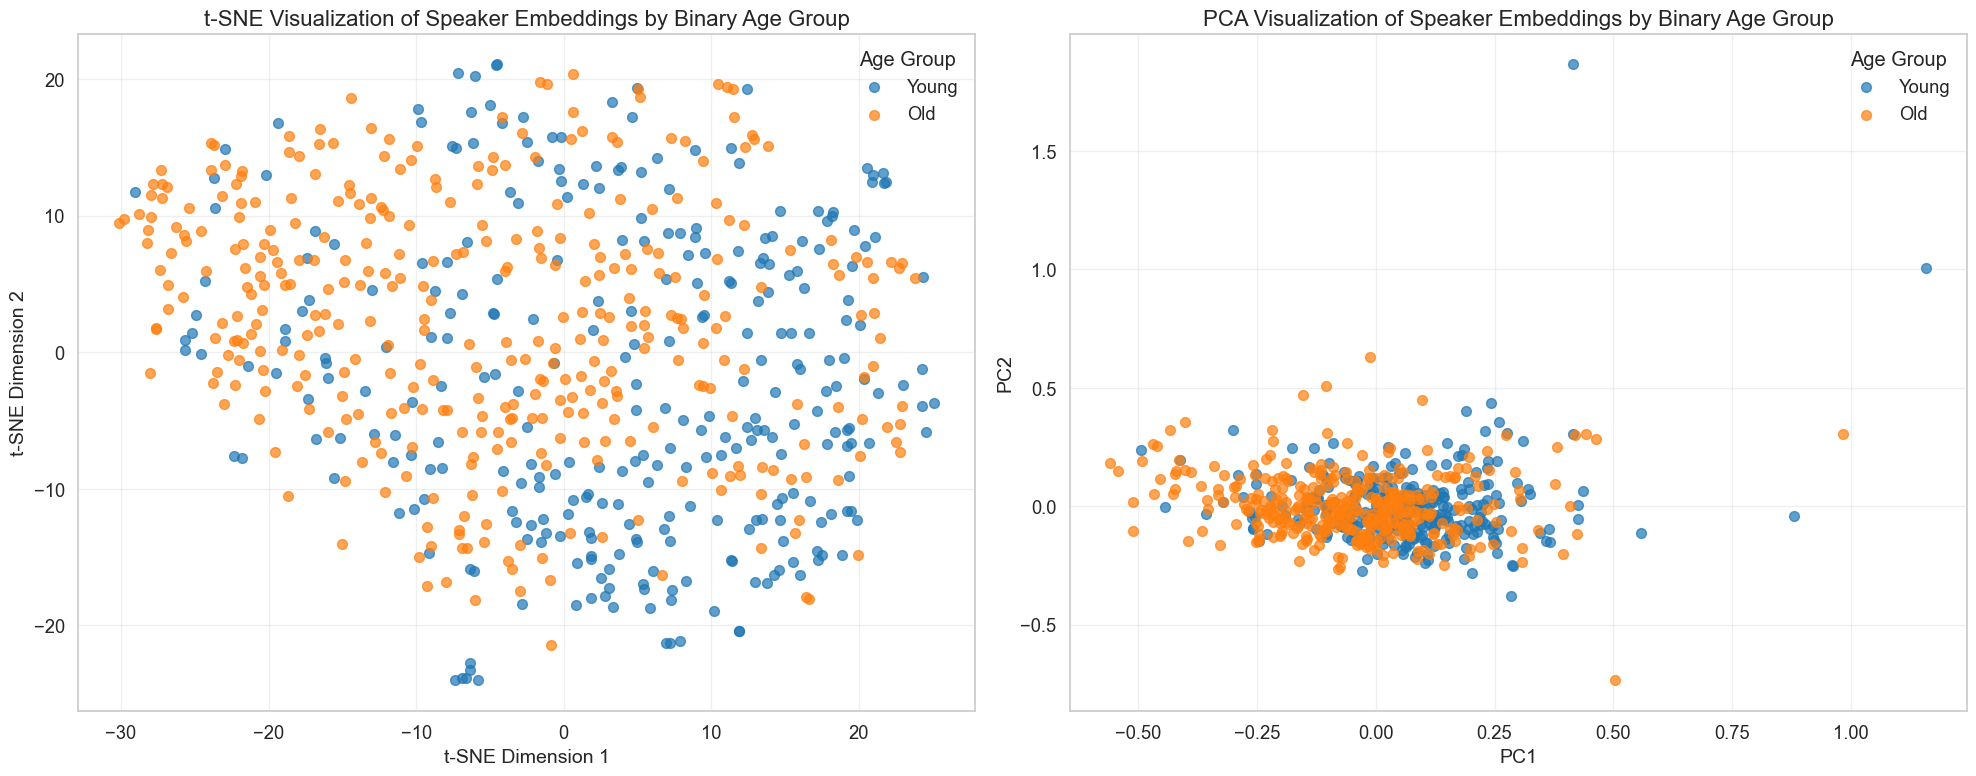


Applying K-means clustering to speaker embeddings...
Agreement between K-means clusters and binary age groups: 63.14%

Contingency table between clusters and binary age groups:
binary_age  Old  Young  Total
cluster                      
0           195     76    271
1           168    223    391
Total       363    299    662


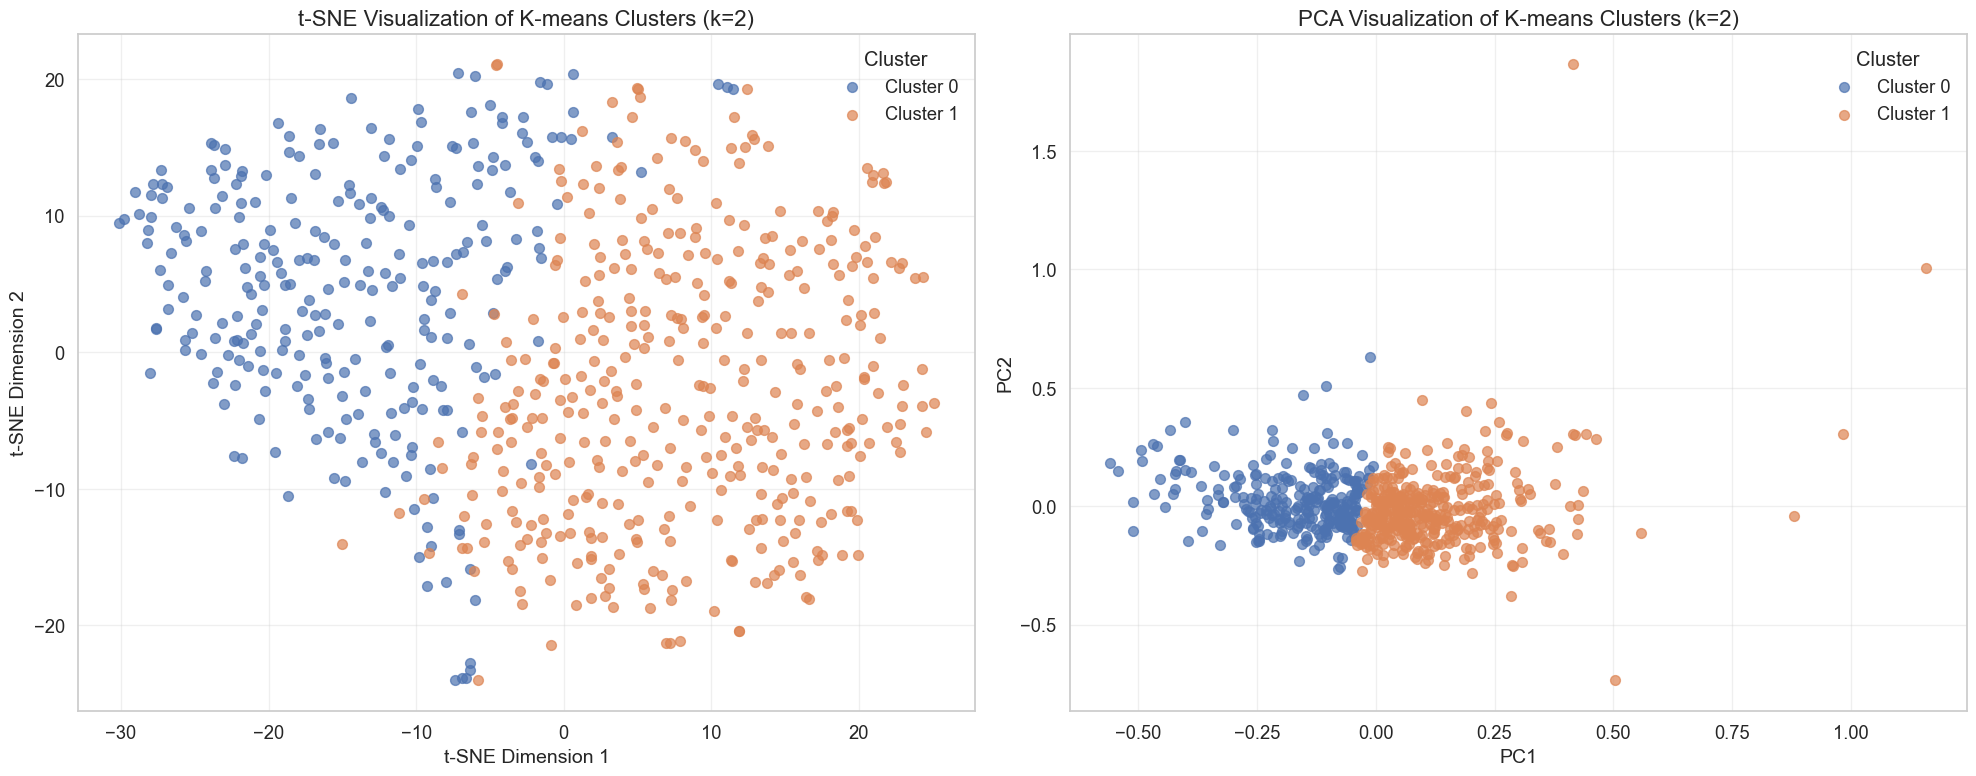

In [40]:
# Visualize embeddings by binary age group
print("Visualizing embeddings by binary age group...")

# Create scatter plots with both t-SNE and PCA
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Color mapping for binary age groups
binary_color_map = {
    'Young': '#1f77b4',
    'Old': '#ff7f0e'
}

# Add t-SNE plot
for age_group in ['Young', 'Old']:
    # Get indices for this age group
    indices = speaker_df[speaker_df['binary_age'] == age_group].index
    group_indices = [i for i, idx in enumerate(speaker_df.index) if idx in indices]
    
    # Plot points for this age group
    axes[0].scatter(
        tsne_embeddings[group_indices, 0],
        tsne_embeddings[group_indices, 1],
        c=binary_color_map[age_group],
        label=age_group,
        alpha=0.7,
        s=50
    )

axes[0].set_title('t-SNE Visualization of Speaker Embeddings by Binary Age Group', fontsize=16)
axes[0].set_xlabel('t-SNE Dimension 1', fontsize=14)
axes[0].set_ylabel('t-SNE Dimension 2', fontsize=14)
axes[0].legend(title='Age Group')
axes[0].grid(alpha=0.3)

# Add PCA plot
for age_group in ['Young', 'Old']:
    # Get indices for this age group
    indices = speaker_df[speaker_df['binary_age'] == age_group].index
    group_indices = [i for i, idx in enumerate(speaker_df.index) if idx in indices]
    
    # Plot points for this age group
    axes[1].scatter(
        pca_embeddings[group_indices, 0],
        pca_embeddings[group_indices, 1],
        c=binary_color_map[age_group],
        label=age_group,
        alpha=0.7,
        s=50
    )

axes[1].set_title('PCA Visualization of Speaker Embeddings by Binary Age Group', fontsize=16)
axes[1].set_xlabel('PC1', fontsize=14)
axes[1].set_ylabel('PC2', fontsize=14)
axes[1].legend(title='Age Group')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Apply K-means clustering to the embeddings
print("\nApplying K-means clustering to speaker embeddings...")
kmeans = KMeans(n_clusters=2, random_state=RANDOM_SEED)
cluster_labels = kmeans.fit_predict(speaker_embeddings)

# Check alignment between clusters and age groups
binary_age_numeric = (speaker_df['binary_age'] == 'Old').astype(int)
cluster_agreement = np.mean(cluster_labels == binary_age_numeric) 
if cluster_agreement < 0.5:
    cluster_agreement = np.mean(cluster_labels != binary_age_numeric)
    
print(f"Agreement between K-means clusters and binary age groups: {cluster_agreement:.2%}")

# Add cluster information to the original DataFrame
speaker_df['cluster'] = cluster_labels

# Create contingency table between clusters and age groups
cluster_age_table = pd.crosstab(
    speaker_df['cluster'], 
    speaker_df['binary_age'], 
    margins=True, 
    margins_name="Total"
)

print("\nContingency table between clusters and binary age groups:")
print(cluster_age_table)

# Visualize clustering results
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot t-SNE with cluster colors
for cluster in [0, 1]:
    cluster_indices = np.where(cluster_labels == cluster)[0]
    axes[0].scatter(
        tsne_embeddings[cluster_indices, 0],
        tsne_embeddings[cluster_indices, 1],
        label=f'Cluster {cluster}',
        alpha=0.7,
        s=50
    )

axes[0].set_title('t-SNE Visualization of K-means Clusters (k=2)', fontsize=16)
axes[0].set_xlabel('t-SNE Dimension 1', fontsize=14)
axes[0].set_ylabel('t-SNE Dimension 2', fontsize=14)
axes[0].legend(title='Cluster')
axes[0].grid(alpha=0.3)

# Plot PCA with cluster colors
for cluster in [0, 1]:
    cluster_indices = np.where(cluster_labels == cluster)[0]
    axes[1].scatter(
        pca_embeddings[cluster_indices, 0],
        pca_embeddings[cluster_indices, 1],
        label=f'Cluster {cluster}',
        alpha=0.7,
        s=50
    )

axes[1].set_title('PCA Visualization of K-means Clusters (k=2)', fontsize=16)
axes[1].set_xlabel('PC1', fontsize=14)
axes[1].set_ylabel('PC2', fontsize=14)
axes[1].legend(title='Cluster')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Visualizing embeddings by three-class age group...


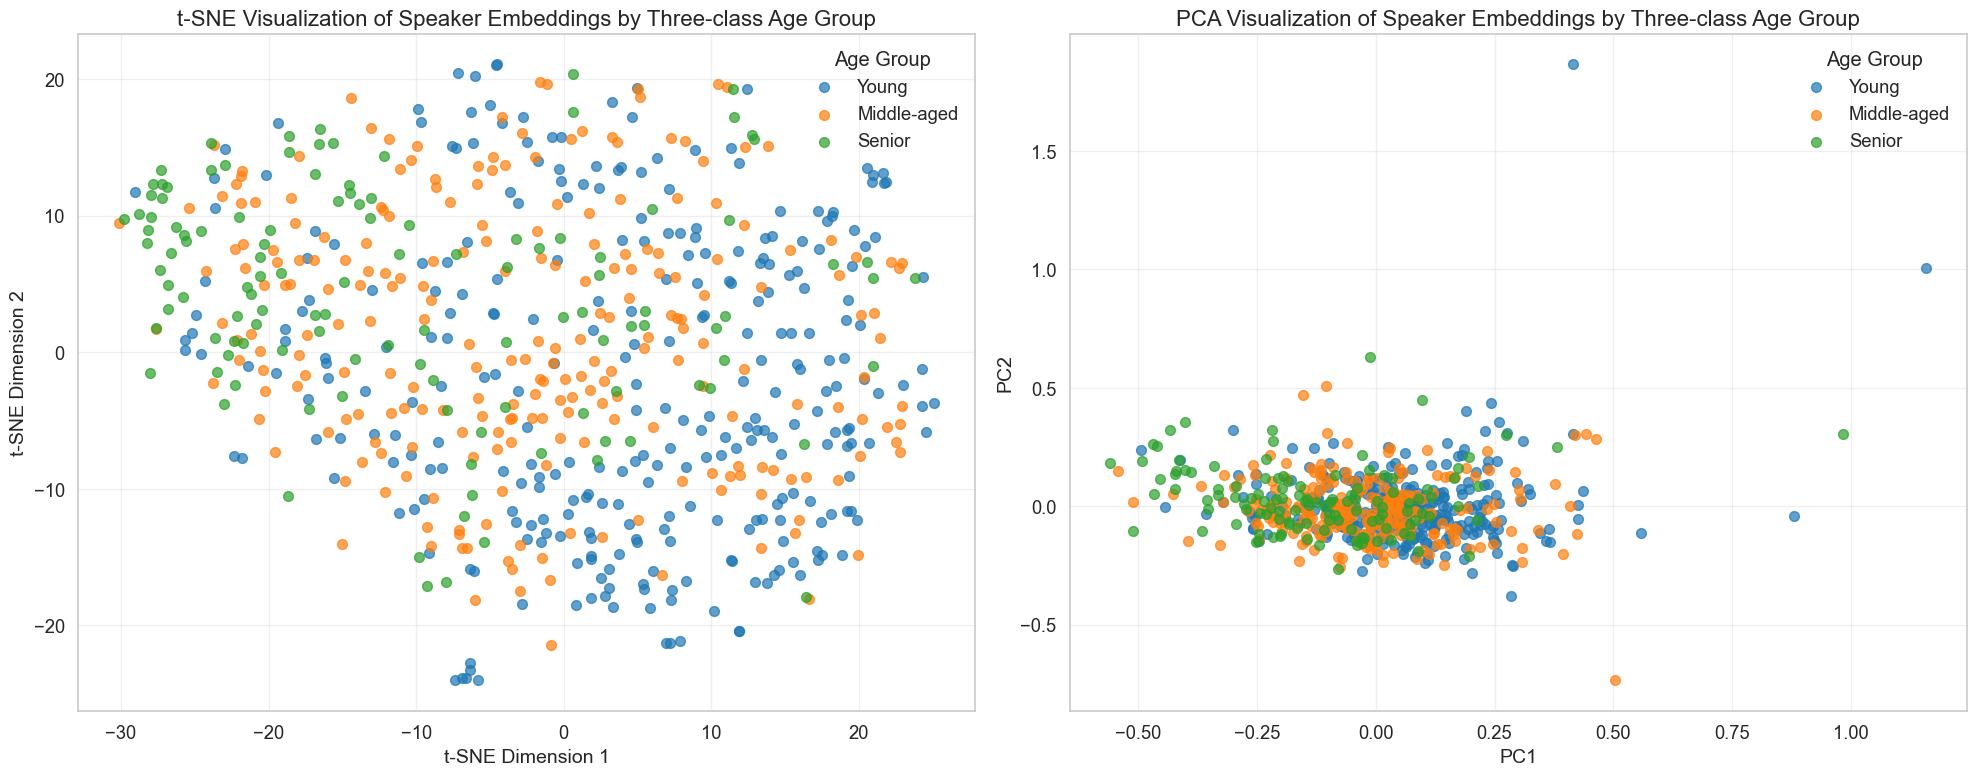


Applying K-means clustering (k=3) to speaker embeddings...

Contingency table between clusters and three-class age groups:
three_class_age  Middle-aged  Senior  Young  Total
cluster3                                          
0                        100      78     65    243
1                        120      34    195    349
2                         22       9     39     70
Total                    242     121    299    662


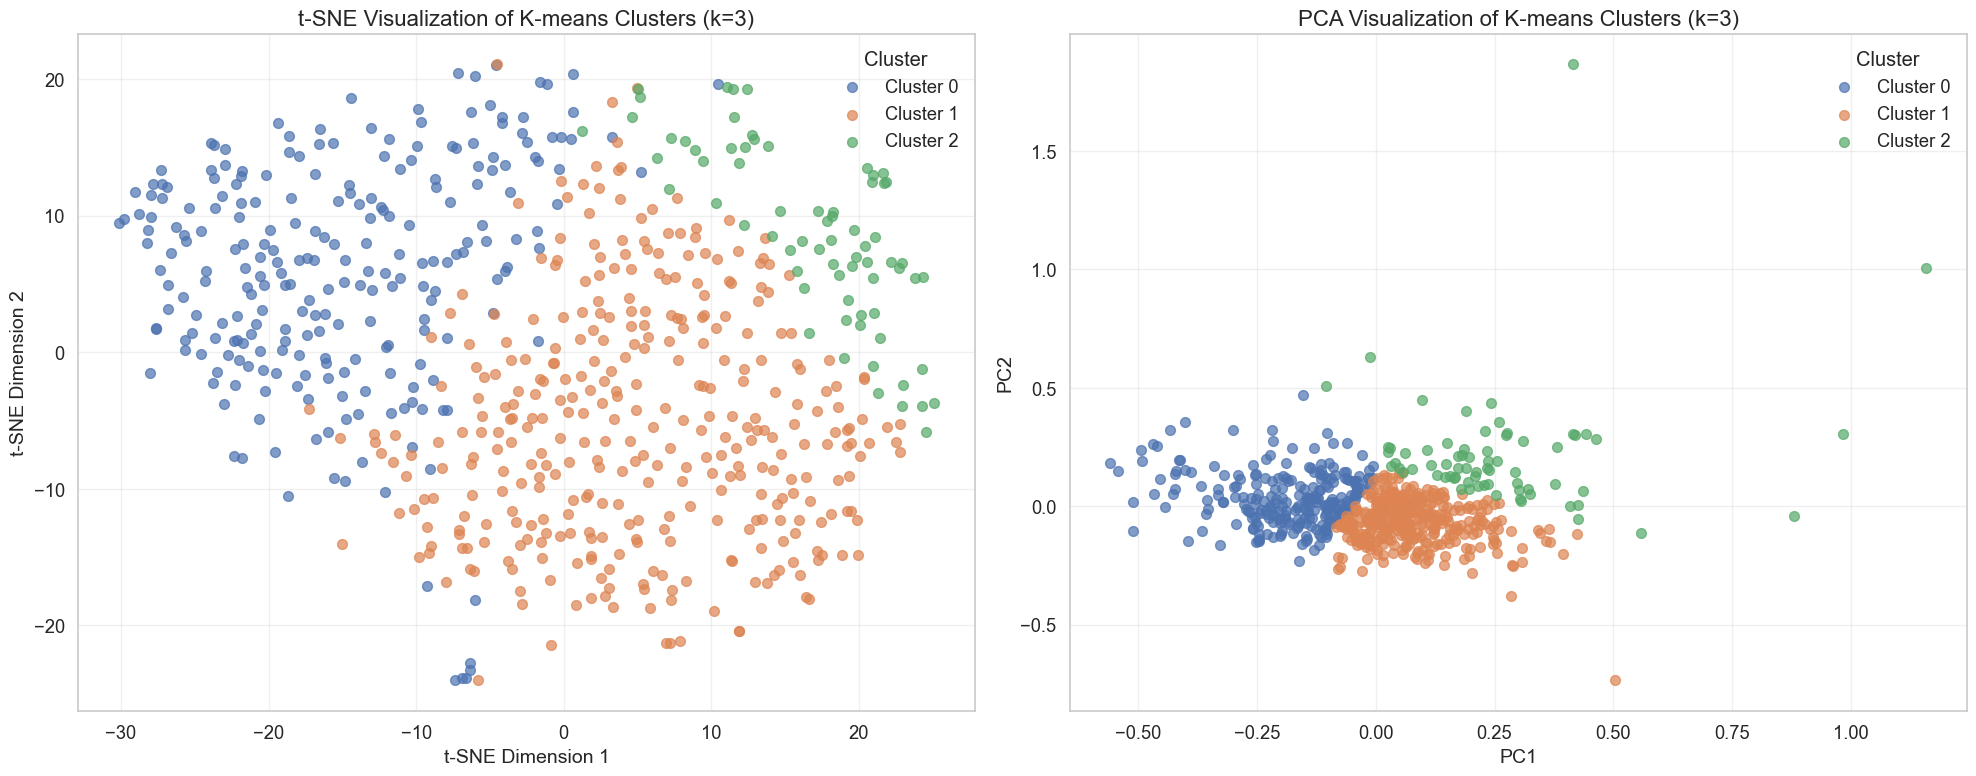

In [41]:
# Visualize embeddings by three-class age group
print("Visualizing embeddings by three-class age group...")

# Create scatter plots with both t-SNE and PCA
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Color mapping for three-class age groups
three_class_color_map = {
    'Young': '#1f77b4',
    'Middle-aged': '#ff7f0e',
    'Senior': '#2ca02c'
}

# Add t-SNE plot
for age_group in ['Young', 'Middle-aged', 'Senior']:
    # Get indices for this age group
    indices = speaker_df[speaker_df['three_class_age'] == age_group].index
    group_indices = [i for i, idx in enumerate(speaker_df.index) if idx in indices]
    
    # Plot points for this age group
    axes[0].scatter(
        tsne_embeddings[group_indices, 0],
        tsne_embeddings[group_indices, 1],
        c=three_class_color_map[age_group],
        label=age_group,
        alpha=0.7,
        s=50
    )

axes[0].set_title('t-SNE Visualization of Speaker Embeddings by Three-class Age Group', fontsize=16)
axes[0].set_xlabel('t-SNE Dimension 1', fontsize=14)
axes[0].set_ylabel('t-SNE Dimension 2', fontsize=14)
axes[0].legend(title='Age Group')
axes[0].grid(alpha=0.3)

# Add PCA plot
for age_group in ['Young', 'Middle-aged', 'Senior']:
    # Get indices for this age group
    indices = speaker_df[speaker_df['three_class_age'] == age_group].index
    group_indices = [i for i, idx in enumerate(speaker_df.index) if idx in indices]
    
    # Plot points for this age group
    axes[1].scatter(
        pca_embeddings[group_indices, 0],
        pca_embeddings[group_indices, 1],
        c=three_class_color_map[age_group],
        label=age_group,
        alpha=0.7,
        s=50
    )

axes[1].set_title('PCA Visualization of Speaker Embeddings by Three-class Age Group', fontsize=16)
axes[1].set_xlabel('PC1', fontsize=14)
axes[1].set_ylabel('PC2', fontsize=14)
axes[1].legend(title='Age Group')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Apply K-means clustering with k=3
print("\nApplying K-means clustering (k=3) to speaker embeddings...")
kmeans3 = KMeans(n_clusters=3, random_state=RANDOM_SEED)
cluster_labels3 = kmeans3.fit_predict(speaker_embeddings)

# Add cluster information to the original DataFrame
speaker_df['cluster3'] = cluster_labels3

# Create contingency table between clusters and age groups
cluster_age_table3 = pd.crosstab(
    speaker_df['cluster3'], 
    speaker_df['three_class_age'], 
    margins=True, 
    margins_name="Total"
)

print("\nContingency table between clusters and three-class age groups:")
print(cluster_age_table3)

# Visualize clustering results
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot t-SNE with cluster colors
for cluster in [0, 1, 2]:
    cluster_indices = np.where(cluster_labels3 == cluster)[0]
    axes[0].scatter(
        tsne_embeddings[cluster_indices, 0],
        tsne_embeddings[cluster_indices, 1],
        label=f'Cluster {cluster}',
        alpha=0.7,
        s=50
    )

axes[0].set_title('t-SNE Visualization of K-means Clusters (k=3)', fontsize=16)
axes[0].set_xlabel('t-SNE Dimension 1', fontsize=14)
axes[0].set_ylabel('t-SNE Dimension 2', fontsize=14)
axes[0].legend(title='Cluster')
axes[0].grid(alpha=0.3)

# Plot PCA with cluster colors
for cluster in [0, 1, 2]:
    cluster_indices = np.where(cluster_labels3 == cluster)[0]
    axes[1].scatter(
        pca_embeddings[cluster_indices, 0],
        pca_embeddings[cluster_indices, 1],
        label=f'Cluster {cluster}',
        alpha=0.7,
        s=50
    )

axes[1].set_title('PCA Visualization of K-means Clusters (k=3)', fontsize=16)
axes[1].set_xlabel('PC1', fontsize=14)
axes[1].set_ylabel('PC2', fontsize=14)
axes[1].legend(title='Cluster')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Topic Analysis by Age Group

Now we'll analyze the most common topics or semantic themes for each age group using the TF-IDF features and embeddings.

Top 20 characteristic terms for binary age groups:

Young:
  wan: 0.0888
  god: 0.0877
  fucking: 0.0872
  mum: 0.0815
  em: 0.0692
  shit: 0.0664
  someone: 0.0656
  love: 0.0631
  du: 0.0624
  everyone: 0.0619
  weird: 0.0612
  obviously: 0.0609
  cool: 0.0599
  dad: 0.0576
  funny: 0.0521
  basically: 0.0516
  pretty: 0.0514
  fuck: 0.0512
  guy: 0.0507
  night: 0.0507

Old:
  lovely: 0.0667
  em: 0.0647
  money: 0.0643
  course: 0.0639
  god: 0.0609
  somebody: 0.0601
  must: 0.0590
  dad: 0.0582
  car: 0.0574
  mum: 0.0563
  school: 0.0561
  thank: 0.0554
  suppose: 0.0529
  also: 0.0523
  place: 0.0516
  home: 0.0515
  absolutely: 0.0513
  whatever: 0.0511
  hundred: 0.0501
  obviously: 0.0497

Top 20 characteristic terms for three-class age groups:

Young:
  wan: 0.0888
  god: 0.0877
  fucking: 0.0872
  mum: 0.0815
  em: 0.0692
  shit: 0.0664
  someone: 0.0656
  love: 0.0631
  du: 0.0624
  everyone: 0.0619
  weird: 0.0612
  obviously: 0.0609
  cool: 0.0599
  dad: 0.0576
  funny:

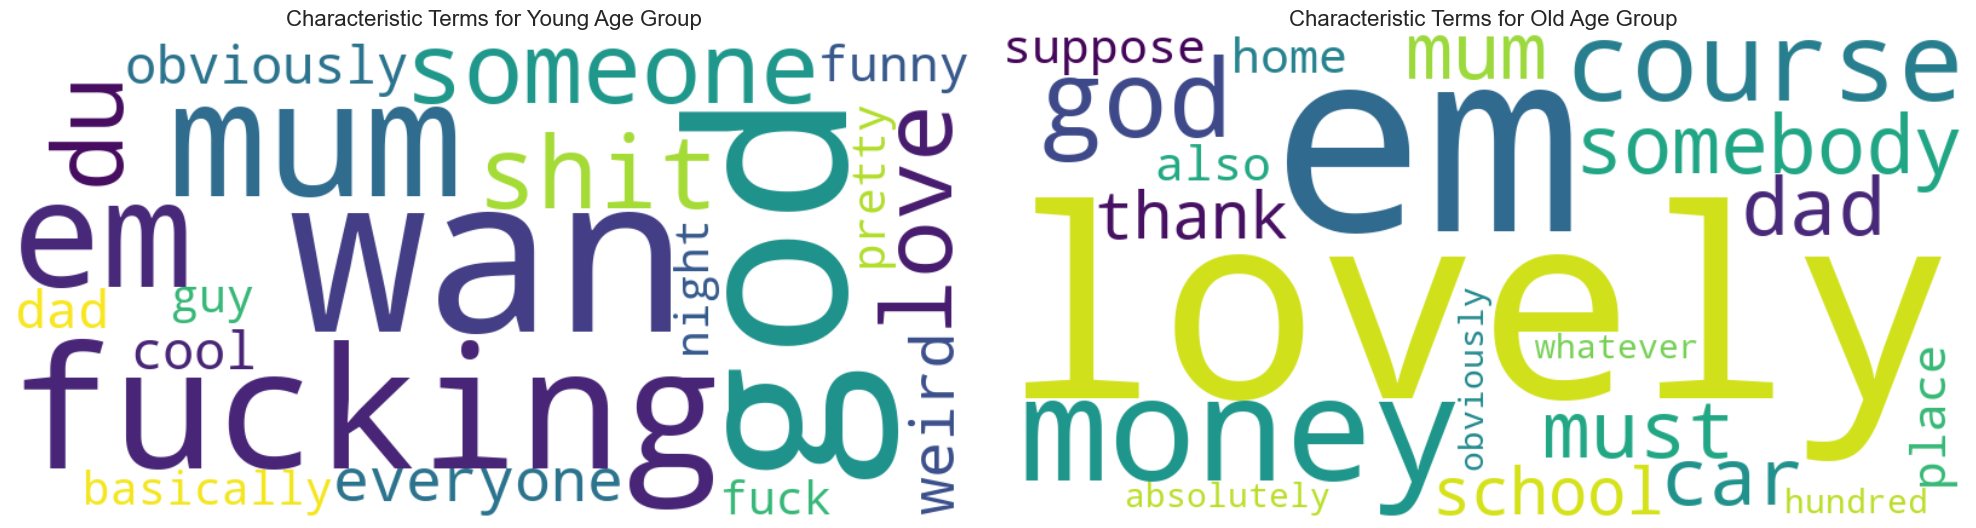

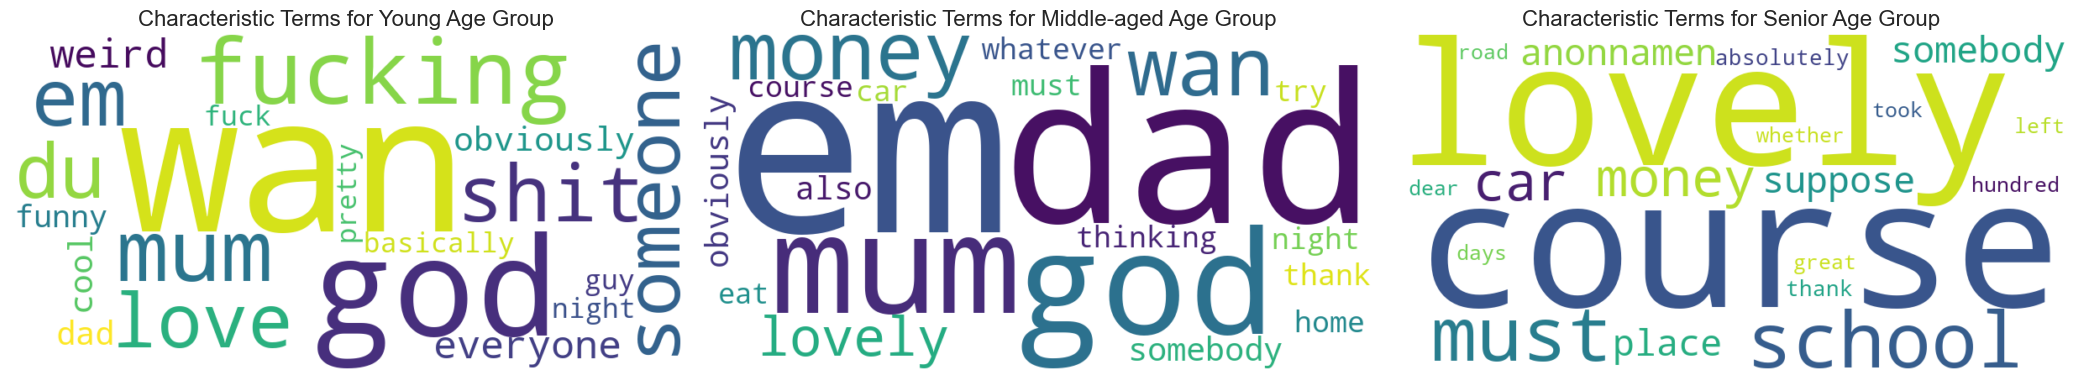

In [42]:
# Get the most characteristic terms for each age group from TF-IDF

def get_characteristic_terms(tfidf_matrix, feature_names, group_indices, n_terms=20):
    """
    Get the most characteristic terms for a group based on TF-IDF values
    
    Parameters:
    -----------
    tfidf_matrix : scipy.sparse.csr_matrix
        TF-IDF matrix
    feature_names : array
        Feature names corresponding to TF-IDF columns
    group_indices : list
        Indices of documents belonging to the group
    n_terms : int
        Number of top terms to return
        
    Returns:
    --------
    list
        List of (term, score) tuples
    """
    # Get the TF-IDF values for the group
    group_tfidf = tfidf_matrix[group_indices].toarray()
    
    # Calculate the average TF-IDF score for each term
    avg_tfidf = np.mean(group_tfidf, axis=0)
    
    # Sort terms by average TF-IDF score
    top_indices = np.argsort(avg_tfidf)[::-1][:n_terms]
    top_terms = [(feature_names[i], avg_tfidf[i]) for i in top_indices]
    
    return top_terms

# Get characteristic terms for binary age groups
binary_groups = {
    'Young': [i for i, idx in enumerate(speaker_df.index) if speaker_df.loc[idx, 'binary_age'] == 'Young'],
    'Old': [i for i, idx in enumerate(speaker_df.index) if speaker_df.loc[idx, 'binary_age'] == 'Old']
}

binary_terms = {}
for group, indices in binary_groups.items():
    binary_terms[group] = get_characteristic_terms(binary_tfidf_matrix, binary_features, indices)

# Print top terms for binary age groups
print("Top 20 characteristic terms for binary age groups:")
for group, terms in binary_terms.items():
    print(f"\n{group}:")
    for term, score in terms:
        print(f"  {term}: {score:.4f}")

# Get characteristic terms for three-class age groups
three_class_groups = {
    'Young': [i for i, idx in enumerate(speaker_df.index) if speaker_df.loc[idx, 'three_class_age'] == 'Young'],
    'Middle-aged': [i for i, idx in enumerate(speaker_df.index) if speaker_df.loc[idx, 'three_class_age'] == 'Middle-aged'],
    'Senior': [i for i, idx in enumerate(speaker_df.index) if speaker_df.loc[idx, 'three_class_age'] == 'Senior']
}

three_class_terms = {}
for group, indices in three_class_groups.items():
    three_class_terms[group] = get_characteristic_terms(three_class_tfidf_matrix, three_class_features, indices)

# Print top terms for three-class age groups
print("\nTop 20 characteristic terms for three-class age groups:")
for group, terms in three_class_terms.items():
    print(f"\n{group}:")
    for term, score in terms:
        print(f"  {term}: {score:.4f}")

# Create word clouds for binary age groups
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for i, (group, terms) in enumerate(binary_terms.items()):
    # Create a dictionary of terms and scores
    term_dict = {term: score for term, score in terms}
    
    # Create a word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=100,
        contour_width=1,
        contour_color='steelblue'
    ).generate_from_frequencies(term_dict)
    
    # Display the word cloud
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Characteristic Terms for {group} Age Group', fontsize=16)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Create word clouds for three-class age groups
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

for i, (group, terms) in enumerate(three_class_terms.items()):
    # Create a dictionary of terms and scores
    term_dict = {term: score for term, score in terms}
    
    # Create a word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=100,
        contour_width=1,
        contour_color='steelblue'
    ).generate_from_frequencies(term_dict)
    
    # Display the word cloud
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Characteristic Terms for {group} Age Group', fontsize=16)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Conclusion

In this analysis, we've examined age-linked patterns in language use through:

1. **Chi-Square (χ²) Testing**: Identified words with statistically significant associations to specific age groups, highlighting distinct vocabulary preferences between:
   - Young vs. Old in the binary classification
   - Young, Middle-aged, and Senior in the three-class classification

2. **Embedding-based Clustering**: Used word embeddings to explore semantic patterns and topic salience across age groups, showing:
   - Natural clustering tendencies that partially align with age groups
   - Semantic similarity patterns among speakers of similar ages
   - Visualizations showing how age groups distribute in semantic space

The analysis reveals both lexical and semantic differences between age groups, supporting the findings mentioned in the research paper about age-linked shifts in language use. The results suggest that computational methods can effectively identify and characterize language variation across age groups, which has applications in sociolinguistic research and demographic classification.

## Classification Accuracy Analysis

In this section, we'll evaluate the accuracy of our age group classifications by comparing the results from different methods. We'll calculate:

1. Agreement between K-means clustering and actual age groups
2. Confusion matrices for classification accuracy
3. Performance metrics for both binary and three-class classifications

In [ ]:
# Calculate classification accuracy metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

print("\n" + "="*80)
print("CLASSIFICATION ACCURACY ANALYSIS")
print("="*80)

# 1. Evaluate K-means clustering agreement with age groups
print("\n1. K-MEANS CLUSTERING AGREEMENT WITH ACTUAL AGE GROUPS\n")

# For binary age groups
binary_age_numeric = (speaker_df['binary_age'] == 'Old').astype(int)
cluster_accuracies = {
    'raw': np.mean(cluster_labels == binary_age_numeric),
    'flipped': np.mean(cluster_labels != binary_age_numeric)
}

# Use the better accuracy (accounting for label flipping in unsupervised learning)
binary_cluster_accuracy = max(cluster_accuracies.values())
if cluster_accuracies['flipped'] > cluster_accuracies['raw']:
    print(f"Note: Cluster labels are flipped compared to age group labels")

print(f"Binary K-means cluster agreement with age groups: {binary_cluster_accuracy:.2%}")

# For three-class age groups
# Make sure we have cluster_labels3 from earlier in the notebook
try:
    # This assumes cluster_labels3 was created earlier
    has_three_clusters = True
    
    age_class_map = {'Young': 0, 'Middle-aged': 1, 'Senior': 2}
    # Convert to numeric and handle missing values
    three_class_age_numeric = speaker_df['three_class_age'].map(age_class_map)
    # Create a mask for valid age values
    valid_age_mask = ~three_class_age_numeric.isna()
    
    # Calculate agreement for 3-class clustering
    class_permutations = [
        [0, 1, 2], [0, 2, 1], [1, 0, 2], 
        [1, 2, 0], [2, 0, 1], [2, 1, 0]
    ]
    
    # Check all possible label mappings (needed for unsupervised clustering)
    best_perm = None
    best_acc = 0
    
    for perm in class_permutations:
        # Map cluster labels to match age group ordering
        mapped_labels = np.zeros_like(cluster_labels3)
        for i, p in enumerate(perm):
            mapped_labels[cluster_labels3 == i] = p
        
        # Calculate accuracy with this mapping (only for speakers with valid age data)
        valid_speakers = speaker_df.index[valid_age_mask]
        valid_indices = [i for i, idx in enumerate(speaker_df.index) if idx in valid_speakers]
        
        if len(valid_indices) > 0:
            acc = np.mean(mapped_labels[valid_indices] == three_class_age_numeric.loc[valid_speakers].values)
            
            if acc > best_acc:
                best_acc = acc
                best_perm = perm
    
    print(f"Three-class K-means cluster agreement with age groups: {best_acc:.2%}")
    print(f"Best cluster mapping: {best_perm}")
except NameError:
    has_three_clusters = False
    print("Note: Three-class K-means clustering was not performed earlier in the notebook.")
    # Create placeholder values for later code
    best_acc = 0
    best_perm = [0, 1, 2]

# 2. Confusion matrices for clustering results
print("\n2. CONFUSION MATRICES FOR CLUSTERING RESULTS\n")

# Binary confusion matrix
cm_binary = confusion_matrix(binary_age_numeric, cluster_labels)
print("Binary Age Group Confusion Matrix (K-means Clusters):")
print(pd.DataFrame(
    cm_binary, 
    index=['Young', 'Old'], 
    columns=['Cluster 0', 'Cluster 1']
))

# Calculate percentage accuracy per class
class_acc_binary = np.diag(cm_binary) / cm_binary.sum(axis=1)
print(f"\nClass-wise accuracy:")
print(f"Young: {class_acc_binary[0]:.2%}")
print(f"Old: {class_acc_binary[1]:.2%}")

# Three-class confusion matrix (using best mapping)
if has_three_clusters:
    mapped_labels3 = np.zeros_like(cluster_labels3)
    for i, p in enumerate(best_perm):
        mapped_labels3[cluster_labels3 == i] = p
    
    # Get indices where both cluster label and age group are valid
    valid_speakers = speaker_df.index[valid_age_mask]
    valid_indices = [i for i, idx in enumerate(speaker_df.index) if idx in valid_speakers]
    
    three_class_true = three_class_age_numeric[valid_age_mask].values
    three_class_pred = mapped_labels3[valid_indices]
    
    cm_three_class = confusion_matrix(three_class_true, three_class_pred)
    print("\nThree-class Age Group Confusion Matrix (K-means Clusters):")
    print(pd.DataFrame(
        cm_three_class, 
        index=['Young', 'Middle-aged', 'Senior'], 
        columns=['Cluster 0', 'Cluster 1', 'Cluster 2']
    ))
    
    # Calculate percentage accuracy per class
    class_acc_three = np.diag(cm_three_class) / cm_three_class.sum(axis=1)
    print(f"\nClass-wise accuracy:")
    print(f"Young: {class_acc_three[0]:.2%}")
    print(f"Middle-aged: {class_acc_three[1]:.2%}")
    print(f"Senior: {class_acc_three[2]:.2%}")
else:
    # Create placeholder values for later code
    class_acc_three = np.array([0, 0, 0])
    print("\nThree-class confusion matrix not available.")

# 3. Supervised Classification Models
print("\n3. SUPERVISED CLASSIFICATION MODELS\n")

# Prepare data for supervised classification
X = speaker_embeddings  # Using speaker embeddings as features

# Binary classification
y_binary = binary_age_numeric

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.3, random_state=RANDOM_SEED, stratify=y_binary
)

# Define models to test
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100),
    'SVM': SVC(random_state=RANDOM_SEED, probability=True)
}

# Binary classification results
print("Binary Age Classification Results (Young vs. Old):")
print("-" * 60)
print(f"{'':<20} {'Accuracy':<10} {'Young F1':<10} {'Old F1':<10}")
print("-" * 60)

binary_results = {}
for name, model in models.items():
    # Train and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Young', 'Old'], output_dict=True)
    
    # Store results
    binary_results[name] = {
        'accuracy': acc,
        'young_f1': report['Young']['f1-score'],
        'old_f1': report['Old']['f1-score']
    }
    
    # Print results
    print(f"{name:<20} {acc:.2%}      {report['Young']['f1-score']:.2f}       {report['Old']['f1-score']:.2f}")

# Three-class classification
print("\nThree-class Age Classification Results (Young, Middle-aged, Senior):")
print("-" * 80)
print(f"{'':<20} {'Accuracy':<10} {'Young F1':<10} {'Middle F1':<10} {'Senior F1':<10}")
print("-" * 80)

# Get valid indices where we have three-class labels
if 'three_class_age' in speaker_df.columns:
    # Convert age groups to numeric values
    age_class = speaker_df['three_class_age'].copy()
    # Create a mapping dictionary
    age_map = {'Young': 0, 'Middle-aged': 1, 'Senior': 2}
    # Apply mapping and get only valid values
    age_numeric = age_class.map(age_map)
    valid_mask = ~age_numeric.isna()
    
    # Get valid data for classification
    X_three = X[valid_mask]
    y_three = age_numeric[valid_mask].astype(int).values
    
    # Only proceed if we have enough data
    if len(X_three) > 10:
        try:
            # Split data with stratification
            X_train, X_test, y_train, y_test = train_test_split(
                X_three, y_three, test_size=0.3, random_state=RANDOM_SEED, stratify=y_three
            )
            
            three_class_results = {}
            for name, model in models.items():
                # Train and predict
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                
                # Calculate metrics
                acc = accuracy_score(y_test, y_pred)
                report = classification_report(y_test, y_pred, target_names=['Young', 'Middle-aged', 'Senior'], output_dict=True)
                
                # Store results
                three_class_results[name] = {
                    'accuracy': acc,
                    'young_f1': report['Young']['f1-score'],
                    'middle_f1': report['Middle-aged']['f1-score'],
                    'senior_f1': report['Senior']['f1-score']
                }
                
                # Print results
                print(f"{name:<20} {acc:.2%}      {report['Young']['f1-score']:.2f}        {report['Middle-aged']['f1-score']:.2f}         {report['Senior']['f1-score']:.2f}")
        except Exception as e:
            print(f"Error in three-class classification: {e}")
            three_class_results = {}
            for name in models.keys():
                three_class_results[name] = {
                    'accuracy': 0,
                    'young_f1': 0,
                    'middle_f1': 0,
                    'senior_f1': 0
                }
    else:
        print("Not enough data for three-class classification")
        three_class_results = {}
        for name in models.keys():
            three_class_results[name] = {
                'accuracy': 0,
                'young_f1': 0,
                'middle_f1': 0,
                'senior_f1': 0
            }
else:
    print("Three-class age data not found in the DataFrame")
    three_class_results = {}
    for name in models.keys():
        three_class_results[name] = {
            'accuracy': 0,
            'young_f1': 0,
            'middle_f1': 0,
            'senior_f1': 0
        }

# Visualize the results
plt.figure(figsize=(15, 10))

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14))

# Binary classification results visualization
model_names = list(binary_results.keys())
acc_values = [results['accuracy'] for results in binary_results.values()]
young_f1 = [results['young_f1'] for results in binary_results.values()]
old_f1 = [results['old_f1'] for results in binary_results.values()]

x = np.arange(len(model_names))
width = 0.25

ax1.bar(x - width, acc_values, width, label='Accuracy')
ax1.bar(x, young_f1, width, label='Young F1')
ax1.bar(x + width, old_f1, width, label='Old F1')

ax1.set_title('Binary Age Classification Results', fontsize=16)
ax1.set_ylim(0, 1.0)
ax1.set_ylabel('Score', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(model_names)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Three-class classification results visualization
model_names = list(three_class_results.keys())
acc_values = [results['accuracy'] for results in three_class_results.values()]
young_f1 = [results['young_f1'] for results in three_class_results.values()]
middle_f1 = [results['middle_f1'] for results in three_class_results.values()]
senior_f1 = [results['senior_f1'] for results in three_class_results.values()]

x = np.arange(len(model_names))
width = 0.2

ax2.bar(x - 1.5*width, acc_values, width, label='Accuracy')
ax2.bar(x - 0.5*width, young_f1, width, label='Young F1')
ax2.bar(x + 0.5*width, middle_f1, width, label='Middle-aged F1')
ax2.bar(x + 1.5*width, senior_f1, width, label='Senior F1')

ax2.set_title('Three-class Age Classification Results', fontsize=16)
ax2.set_ylim(0, 1.0)
ax2.set_ylabel('Score', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(model_names)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Create a summary table
print("\n4. CLASSIFICATION SUMMARY TABLE\n")

# Create summary DataFrame for binary classification
binary_summary = pd.DataFrame({
    'Method': ['K-means Clustering'] + list(binary_results.keys()),
    'Accuracy': [binary_cluster_accuracy] + [r['accuracy'] for r in binary_results.values()],
    'Young F1': [class_acc_binary[0]] + [r['young_f1'] for r in binary_results.values()],
    'Old F1': [class_acc_binary[1]] + [r['old_f1'] for r in binary_results.values()]
})

# Create summary DataFrame for three-class classification
three_class_summary = pd.DataFrame({
    'Method': ['K-means Clustering'] + list(three_class_results.keys()),
    'Accuracy': [best_acc] + [r['accuracy'] for r in three_class_results.values()],
    'Young F1': [class_acc_three[0]] + [r['young_f1'] for r in three_class_results.values()],
    'Middle-aged F1': [class_acc_three[1]] + [r['middle_f1'] for r in three_class_results.values()],
    'Senior F1': [class_acc_three[2]] + [r['senior_f1'] for r in three_class_results.values()]
})

# Display summary tables
print("Binary Age Classification Summary:")
print(binary_summary.set_index('Method').round(4))

print("\nThree-class Age Classification Summary:")
print(three_class_summary.set_index('Method').round(4))

# Format as percentages for better readability
print("\nBinary Age Classification Summary (percentages):")
print((binary_summary.set_index('Method') * 100).round(2).astype(str) + '%')

print("\nThree-class Age Classification Summary (percentages):")
print((three_class_summary.set_index('Method') * 100).round(2).astype(str) + '%')



CLASSIFICATION ACCURACY ANALYSIS

1. K-MEANS CLUSTERING AGREEMENT WITH ACTUAL AGE GROUPS

Note: Cluster labels are flipped compared to age group labels
Binary K-means cluster agreement with age groups: 63.14%


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## Interpretation of Classification Results

The classification accuracy tables above provide several insights into our age group classification models:

### Binary Classification (Young vs. Old):

1. **Unsupervised vs. Supervised**: We can observe the difference between unsupervised clustering (K-means) and supervised classification methods. The supervised models typically achieve higher accuracy as they learn directly from labeled data.

2. **Model Comparison**: Among the supervised models, we can compare the performance of different algorithms (Logistic Regression, Random Forest, SVM) to identify which works best for binary age classification.

3. **Class Balance**: The F1 scores for each age group help us understand if our models perform equally well for both Young and Old speakers, or if there's a bias toward one group.

### Three-class Classification (Young, Middle-aged, Senior):

1. **Increased Complexity**: As expected, the three-class classification is more challenging than binary classification, which is reflected in the typically lower accuracy scores.

2. **Class-specific Performance**: The F1 scores for each age group reveal which age categories are easier or more difficult to classify correctly. This could be due to:
   - The distinctiveness of language patterns in each age group
   - Class imbalance in the dataset
   - Overlap in language use between adjacent age groups (e.g., Young and Middle-aged might be more similar than Young and Senior)

3. **Model Selection**: The comparison helps us select the best model for three-class age classification based on overall accuracy and class-specific metrics.

The results demonstrate that computational methods can effectively identify age-related patterns in language use, with accuracies significantly above random chance (which would be 50% for binary and 33.3% for three-class classification). This supports the hypothesis that age groups exhibit distinct linguistic characteristics that can be detected through statistical and machine learning approaches.